In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
import os
PATH = os.getcwd()
sys.path.append(PATH)

In [2]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np
import random

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support

from sklearn.utils import resample

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

#from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
#import catboost

# from tensorflow.keras.backend import print_tensor
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers.core import Dense, Activation, Dropout
# from keras.preprocessing import sequence
# from keras.models import Sequential, Model, load_model
# from keras.layers import Dense, Embedding, Flatten, Input
# from keras.layers import LSTM
# from keras.optimizers import Nadam, RMSprop
# from tensorflow.keras.utils import plot_model
# from keras.layers.normalization import BatchNormalization

import seaborn as sns

#import lime
#import lime.lime_tabular
#from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import joblib

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def train_with_unbalanced_data(X_train, X_test, feature_combiner, dataset_manager, current_args, scaler = None, iterations = 10):
  all_pipelines = []
  all_cls = []
  all_acc = []

  for j in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(pos_cases, len(neg_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "xgboost":
        cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
        cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)
    elif cls_method == "nb":
        cls = GaussianNB(var_smoothing=current_args['var_smoothing'])

    pipeline = Pipeline([('encoder', feature_combiner), ('scaler', MinMaxScaler()), ('cls', cls)])
    
    print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]
    
    #print(np.unique(y_train_resampled, return_counts=True))
    #print(np.unique(y_test, return_counts=True))

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = f1_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  index = all_acc.index(max(all_acc))
    
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", index)

  pipeline = all_pipelines[index]
  cls = all_cls[index]

  return pipeline, cls

In [4]:
dataset_ref = "bpic2012"
params_dir = PATH + "/params/"
results_dir = "results"

bucket_method = "single"
cls_encoding = "agg"

gap = 1
n_iter = 1

balanced_data = True

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    "bpic2012" : ["bpic2012_accepted"],
    "sepsis_cases": ["sepsis_cases_1"],
    "production" : ["production"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "3d":[]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22
max_prefix = 15

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['bpic2012_accepted']


In [5]:
for dataset_name in datasets:
    
           
    # read the data
    print("setting up data...")
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    max_prefix_length = max_prefix

    dt_train_prefixes = pd.read_csv(os.path.join(PATH, "%s/datasets/train_prefixes.csv" % (dataset_ref)))
    dt_test_prefixes = pd.read_csv(os.path.join(PATH, "%s/datasets/test_prefixes.csv" % (dataset_ref)))
    dt_val_prefixes = pd.read_csv(os.path.join(PATH, "%s/datasets/val_prefixes.csv" % (dataset_ref)))
        
    dt_train_prefixes = pd.concat([dt_train_prefixes, dt_val_prefixes])

    dt_train_prefixes = dataset_manager.generate_prefix_data(dt_train_prefixes, min_prefix_length, max_prefix_length)
    dt_test_prefixes = dataset_manager.generate_prefix_data(dt_test_prefixes, min_prefix_length, max_prefix_length)
    
    test_y_all = []
    preds_all = []
    pipelines = []

    for ii in range(n_iter):
        # create prefix logs
        print("Creating logs...")
#           dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)

        # Bucketing prefixes based on control flow
        print("bucketing prefixes...")
        bucketer_args = {'encoding_method':bucket_encoding,
                         'case_id_col':dataset_manager.case_id_col, 
                         'cat_cols':[dataset_manager.activity_col], 
                         'num_cols':[], 
                         'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        bucket_assignments_test = bucketer.predict(dt_test_prefixes)
                
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket )
            print("sorting bucket...")
            
             # load optimal params
            print("Setting up parameters...")
            optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s_bucket_%s.pickle" 
                                                   % (cls_method, dataset_name, method_name, bucket))

            if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
                print("Parameters not found")

            with open(optimal_params_filename, "rb") as fin:
                current_args = pickle.load(fin)

            print(current_args)
            
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)

            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                else:
                    print("choosing classifier...")
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if balanced_data==False:
                        pipeline, cls = train_with_unbalanced_data(dt_train_bucket, dt_test_bucket, feature_combiner, dataset_manager, current_args, iterations = 10)

                    else:
                        if cls_method == "xgboost":
                            cls = xgb.XGBClassifier(objective='binary:logistic',
                                                  n_estimators=500,
                                                  learning_rate= current_args['learning_rate'],
                                                  subsample=current_args['subsample'],
                                                  max_depth=int(current_args['max_depth']),
                                                  colsample_bytree=current_args['colsample_bytree'],
                                                  min_child_weight=int(current_args['min_child_weight']),
                                                  seed=random_state)

                        elif cls_method == "logit":
                            cls = LogisticRegression(C=2**current_args['C'],
                                                  random_state=random_state)
                        elif cls_method == "nb":
                            cls = GaussianNB(var_smoothing=current_args['var_smoothing'])

                        pipeline = Pipeline([('encoder', feature_combiner), ('scaler', MinMaxScaler()), ('cls', cls)])
                        
                        print("fitting pipeline...")
                        pipeline.fit(dt_train_bucket, train_y)
                
                preds = pipeline.predict(dt_test_bucket)
                test_y = dataset_manager.get_label_numeric(dt_test_bucket)
                
                print(classification_report(test_y, preds))
                
                test_y_all.extend(test_y)
                preds_all.extend(preds)
                pipelines.append(pipeline)
                
                if bucket_method == "prefix":
                    sample_dfs = []
                    pipeline_path = os.path.join(PATH, "%s/%s/%s/pipelines/pipeline_bucket_%s.joblib" 
                                                 % (dataset_ref, cls_method, method_name, bucket))
                    joblib.dump(pipeline, pipeline_path)
                    
                    dt_train_data = pd.DataFrame(feature_combiner.transform(dt_train_bucket), 
                                                   columns = feature_combiner.get_feature_names())
                    
                    dt_train_data.to_csv(os.path.join(PATH, "%s/%s/%s/train_data/train_data_bucket_%s.csv" 
                                                 % (dataset_ref, cls_method, method_name, bucket)), index=False)

                    
                    if len(dataset_manager.get_case_ids(dataset_manager.balance_data(dt_test_bucket))) < 50:
                        #print("Cases in test data:", len(dataset_manager.get_case_ids(dt_test_bucket)))
                        choose_from = pd.concat([dt_train_bucket, dt_test_bucket])
                        
                    else:
                        #print(len(data_manager.get_case_ids(dt_test_bucket)), "cases in test data")
                        choose_from = dt_test_bucket
                        
                    all_y = dataset_manager.get_label_numeric(choose_from)
                    case_ids = dataset_manager.get_case_ids(choose_from)

                    neg_cases = [case_ids[i] for i in range(len(case_ids)) if all_y[i] == 0]
                    pos_cases = [case_ids[i] for i in range(len(case_ids)) if all_y[i] == 1]

                    sample_length = min(len(neg_cases), len(pos_cases), 25)
                    #print(len(neg_cases),len(pos_cases))

                    neg_cases = random.sample(neg_cases, sample_length)
                    pos_cases = random.sample(pos_cases, sample_length)

                    bal_sample = choose_from.loc[choose_from[dataset_manager.case_id_col].isin(neg_cases)]
                    bal_sample = bal_sample.append(choose_from.loc[choose_from[dataset_manager.case_id_col].isin(pos_cases)])
                    
                    sample_dfs.append(bal_sample)
                    bal_sample = pd.concat(sample_dfs)
                    
                    sample_ids = []
                    sample_y = []
                    sample_lens = []
                    preds = []
                    probas = []

                    encoded_dfs = []

                    for _,group in bal_sample.groupby(dataset_manager.case_id_col):

                        sample_ids.append(dataset_manager.get_case_ids(group)[0])
                        sample_y.append(dataset_manager.get_label_numeric(group)[0])
                        sample_lens.append(dataset_manager.get_prefix_lengths(group).iloc[0])

                        pred = int(pipeline.predict(group))
                        proba = pipeline.predict_proba(group).reshape(-1)[pred]
                        preds.append(pred)
                        probas.append(proba)

                        encoded_dfs.append(pd.DataFrame(feature_combiner.transform(group), 
                                                        columns = feature_combiner.get_feature_names()))

                    encoded_sample = pd.concat(encoded_dfs)

                    rows = np.array([sample_ids, sample_y, sample_lens, preds, probas]).transpose()
                    columns = ['Case ID', 'Actual', 'Prefix Length', 'Prediction', 'Prediction Probability']
                    results_template = pd.DataFrame(rows, columns = columns)

                    encoded_sample.to_csv(os.path.join(PATH,"%s/%s/%s/samples/test_sample_bucket_%s.csv") 
                                          % (dataset_ref, cls_method, method_name, bucket), index=False)
                    results_template.to_csv(os.path.join(PATH,"%s/%s/%s/samples/results_bucket_%s.csv") 
                                            % (dataset_ref, cls_method, method_name, bucket), index=False)
                
        print("All buckets\n", classification_report(test_y_all, preds_all))
        
        if bucket_method == "single":
            sample_dfs = []
            pipeline_path = os.path.join(PATH, "%s/%s/%s/pipelines/pipeline_bucket_%s.joblib" 
                                                 % (dataset_ref, cls_method, method_name, bucket))
            joblib.dump(pipeline, pipeline_path)
            
            dt_train_data = pd.DataFrame(feature_combiner.transform(dt_train_bucket), 
                                                   columns = feature_combiner.get_feature_names())
            dt_train_data.to_csv(os.path.join(PATH, "%s/%s/%s/train_data/train_data_bucket_%s.csv" 
                                                 % (dataset_ref, cls_method, method_name, bucket)), index=False)

            if len(dataset_manager.get_case_ids(dataset_manager.balance_data(dt_test_bucket))) < 1000:
                #print("Cases in balanced test data:", len(dataset_manager.get_case_ids(dataset_manager.balance_data(dt_test_prefixes))))   
                choose_from = pd.concat([dt_train_bucket, dt_test_bucket])
                
            else:
                #print(len(data_manager.get_case_ids(dt_test_bucket)), "cases in balanced test data")
                choose_from = dt_test_bucket
            
            #sample_dfs = []    
            for length in range(max_prefix+1):
                choose_from_len = choose_from[choose_from['prefix_nr']==length]
                all_y = dataset_manager.get_label_numeric(choose_from_len)
                case_ids = dataset_manager.get_case_ids(choose_from_len)

                neg_cases = [case_ids[i] for i in range(len(case_ids)) if all_y[i] == 0]
                pos_cases = [case_ids[i] for i in range(len(case_ids)) if all_y[i] == 1]

                sample_length = min(len(neg_cases), len(pos_cases), 25)
                #print(len(neg_cases),len(pos_cases))

                neg_cases = random.sample(neg_cases, sample_length)
                pos_cases = random.sample(pos_cases, sample_length)

                bal_sample = choose_from.loc[choose_from[dataset_manager.case_id_col].isin(neg_cases)]
                bal_sample = bal_sample.append(choose_from.loc[choose_from[dataset_manager.case_id_col].isin(pos_cases)])
                
                sample_dfs.append(bal_sample)
                
            bal_sample = pd.concat(sample_dfs)
                
            sample_ids = []
            sample_y = []
            sample_lens = []
            preds = []
            probas = []

            encoded_dfs = []

            for _,group in bal_sample.groupby(dataset_manager.case_id_col):

                sample_ids.append(dataset_manager.get_case_ids(group)[0])
                sample_y.append(dataset_manager.get_label_numeric(group)[0])
                sample_lens.append(dataset_manager.get_prefix_lengths(group).iloc[0])

                pred = int(pipeline.predict(group))
                proba = pipeline.predict_proba(group).reshape(-1)[pred]
                preds.append(pred)
                probas.append(proba)

                encoded_dfs.append(pd.DataFrame(feature_combiner.transform(group), 
                                                        columns = feature_combiner.get_feature_names()))
            encoded_sample = pd.concat(encoded_dfs)

            rows = np.array([sample_ids, sample_y, sample_lens, preds, probas]).transpose()
            columns = ['Case ID', 'Actual', 'Prefix Length', 'Prediction', 'Prediction Probability']
            results_template = pd.DataFrame(rows, columns = columns)

            encoded_sample.to_csv(os.path.join(PATH,"%s/%s/%s/samples/test_sample_bucket_%s.csv") 
                                  % (dataset_ref, cls_method, method_name, bucket), index=False)
            results_template.to_csv(os.path.join(PATH,"%s/%s/%s/samples/results_bucket_%s.csv") 
                                    % (dataset_ref, cls_method, method_name, bucket), index=False)

setting up data...
Creating logs...
bucketing prefixes...
single
Bucket 1
sorting bucket...
Setting up parameters...
{'colsample_bytree': 0.6019404158543714, 'learning_rate': 0.0969576422036128, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 80, 'subsample': 0.6695092256018549}
choosing classifier...
fitting pipeline...
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      6825
           1       0.55      0.46      0.50      7230

    accuracy                           0.53     14055
   macro avg       0.53      0.53      0.53     14055
weighted avg       0.53      0.53      0.52     14055

All buckets
               precision    recall  f1-score   support

           0       0.51      0.60      0.55      6825
           1       0.55      0.46      0.50      7230

    accuracy                           0.53     14055
   macro avg       0.53      0.53      0.53     14055
weighted avg       0.53      0.53      0.52     14055



In [6]:
results_template['Prefix Length'].value_counts()

1     50
10    50
5     50
11    50
14    50
7     50
8     50
9     50
13    50
2     50
6     50
12    50
15    50
3     50
4     50
Name: Prefix Length, dtype: int64

<AxesSubplot:>

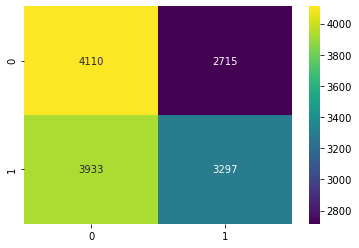

In [7]:
confusion = confusion_matrix(test_y_all, preds_all)
sns.heatmap(confusion, annot=True, fmt='d', cmap='viridis')#, categories = ['Negative', 'Positive'])

In [8]:
dt_train_data.shape

(55649, 122)

In [9]:
encoded_sample.shape

(750, 122)